In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# this data set contains the most relevant alarms 
data = pd.read_csv('./dataframes/clean_data.csv')
data_bck=data.copy()

# Alarms sets creation

In [3]:
data.head()

,Unnamed: 0,DateTime,rounding,Nr per 10,date,unique_alarms_date,MsgNr,Ms,State,dt,...,Year-Week,seconds_diff,dependence_bigger10min,dependence_5-10min,dependence_1-5min,dependence_1min,inverted,output,new_output,sequences
0,0,2022-01-03 05:49:49,2022-01-03 05:40:00,1,2022-01-03,140,50217,851,1,0,...,2022-01,NaN,1,0,0,1,NaN,0,0.0,0
1,1,2022-01-03 08:41:45,2022-01-03 08:40:00,10,2022-01-03,140,15042,571,1,0,...,2022-01,10316.0,1,0,0,1,1.0,0,0.0,0
2,2,2022-01-03 08:44:22,2022-01-03 08:40:00,10,2022-01-03,140,4074,129,1,0,...,2022-01,157.0,0,0,1,1,1.0,0,0.0,0
3,3,2022-01-03 08:46:40,2022-01-03 08:40:00,10,2022-01-03,140,15042,908,1,0,...,2022-01,138.0,0,0,1,1,1.0,0,0.0,0
4,4,2022-01-03 09:07:11,2022-01-03 09:00:00,6,2022-01-03,140,15042,731,1,0,...,2022-01,1231.0,1,0,0,1,1.0,0,0.0,0


In [4]:
transactions = data.groupby('sequences')['MsgNr'].apply(list).tolist()
transactions.pop(0)
transactions[166]

[11232, 11231, 11231, 11231, 11231, 11231, 11231, 11231, 11231, 11232]

In [5]:
data_bck = data.copy()

In [6]:
len(transactions)

47597

# Validation of sets

In [7]:
data['Plant'].unique()

array(['L-Ende UV136', 'Emissionsmessung', 'Rekuperator', 'ACON/E-Welle',
       'BiMi-Lager',
       'Schw.SpaltsÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚Â¤g',
       'LiniensÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚Â¤gen',
       'Abfallbeh. UV42', 'ACON', 'CO_Curingoven', 'Div_Saw', 'Wickler',
       'Bindemittel', 'Sammelkam.', 'Chargierung', 'LiniensÃ¤gen',
       'LiniensÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚Â¤gen',
       'Schw.SpaltsÃ¤g',
       'Schw.SpaltsÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚Â‚ÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚Âƒ

Chargierung - -Rekuperator/BiMi-Lager - Bindemittel', 'Sammelkam- ACON/E-Welle /ACON - CO_Curingoven - Schw.Spalts/LiniensÃƒÂƒÃ/Div_Saw - Wickler- L-Ende UV136 - Abfallbeh. UV42

data['new_output'] = data['output'].shift(-1)
data['sequences'] = data['output']
data.loc[data['new_output'] >= data['output'], 'sequences'] = data['new_output']
data[:15]

# Alarm Exploration

## Chattering Alarms

In [8]:
#total number of alarms in sets
alarms_in_transactions = sum([len(sublist) for sublist in transactions])
print('total number of alarms in sets:', alarms_in_transactions)

total number of alarms in sets: 313717


In [9]:
#removing chattering alarms
transactions_clean = [set(i) for i in transactions]

#count number of unique alarms per set
number_clean = sum([len(sublist) for sublist in transactions_clean])
print('total unique alarms in sets', number_clean)

total unique alarms in sets 109723


Text(0, 0.5, 'times')

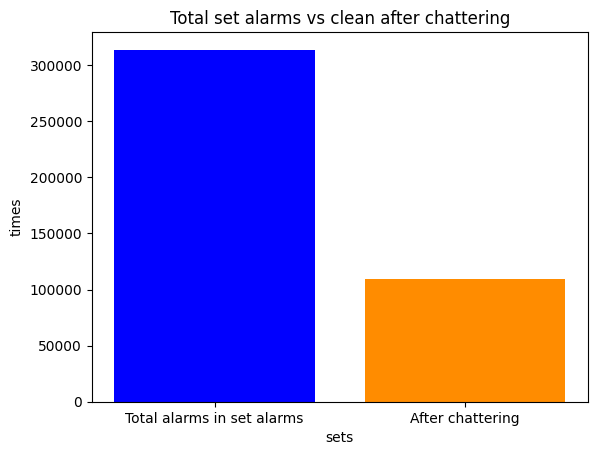

In [10]:
# plot the results
plt.bar(['Total alarms in set alarms', 'After chattering'], [alarms_in_transactions, number_clean], color = ["blue", "darkorange"])
plt.title('Total set alarms vs clean after chattering')
plt.xlabel("sets")
plt.ylabel("times")

## Plotting alarms

In [11]:
#select the first alarm of each set
activation_alarms = [item[0] for item in transactions]

In [12]:
# count how many times one alarm is the activation
df = pd.DataFrame(activation_alarms, columns=['MsgNr'])
grouped_activation = pd.DataFrame(df.groupby(['MsgNr'])['MsgNr'].count()).rename(columns={'MsgNr': 'times'})
grouped_activation.head()

,times
MsgNr,
2421,411
2445,411
4074,685
4203,1464
6269,671


In [13]:
# count the total number of alarms (including the repeated)
flat_alarms = [item for sublist in transactions for item in sublist]
df_alarms = pd.DataFrame(flat_alarms, columns = ['alarms'])
grouped_total = pd.DataFrame(df_alarms.groupby(['alarms'])['alarms'].count()).rename(columns={'alarms': 'times'})
grouped_total.head()

,times
alarms,
2421,1397
2445,1989
4074,2125
4203,4489
6269,1572


In [14]:
# count the total number of alarms (excluding the repeated)
after_chattering_list = [item for sublist in transactions_clean for item in sublist]
df_chattering = pd.DataFrame(after_chattering_list, columns = ['alarms'])
grouped_total_chattering = pd.DataFrame(df_chattering.groupby(['alarms'])['alarms'].count()).rename(columns={'alarms': 'times'})
grouped_total_chattering.head()

,times
alarms,
2421,867
2445,626
4074,1919
4203,3428
6269,811


In [17]:
# grouped_total_chattering.rename(columns={'times_chatter': 'chatter'}, inplace=True)
# grouped_activation.rename(columns={'times_activation': 'activation'}, inplace=True)

In [15]:
df_merged = grouped_total_chattering.merge(grouped_activation, how= "inner", left_index=True, right_index=True)
df_merged['difference'] = df_merged['times_x'] - df_merged['times_y']
df_merged.head()

,times_x,times_y,difference
alarms,,,
2421,867,411,456
2445,626,411,215
4074,1919,685,1234
4203,3428,1464,1964
6269,811,671,140


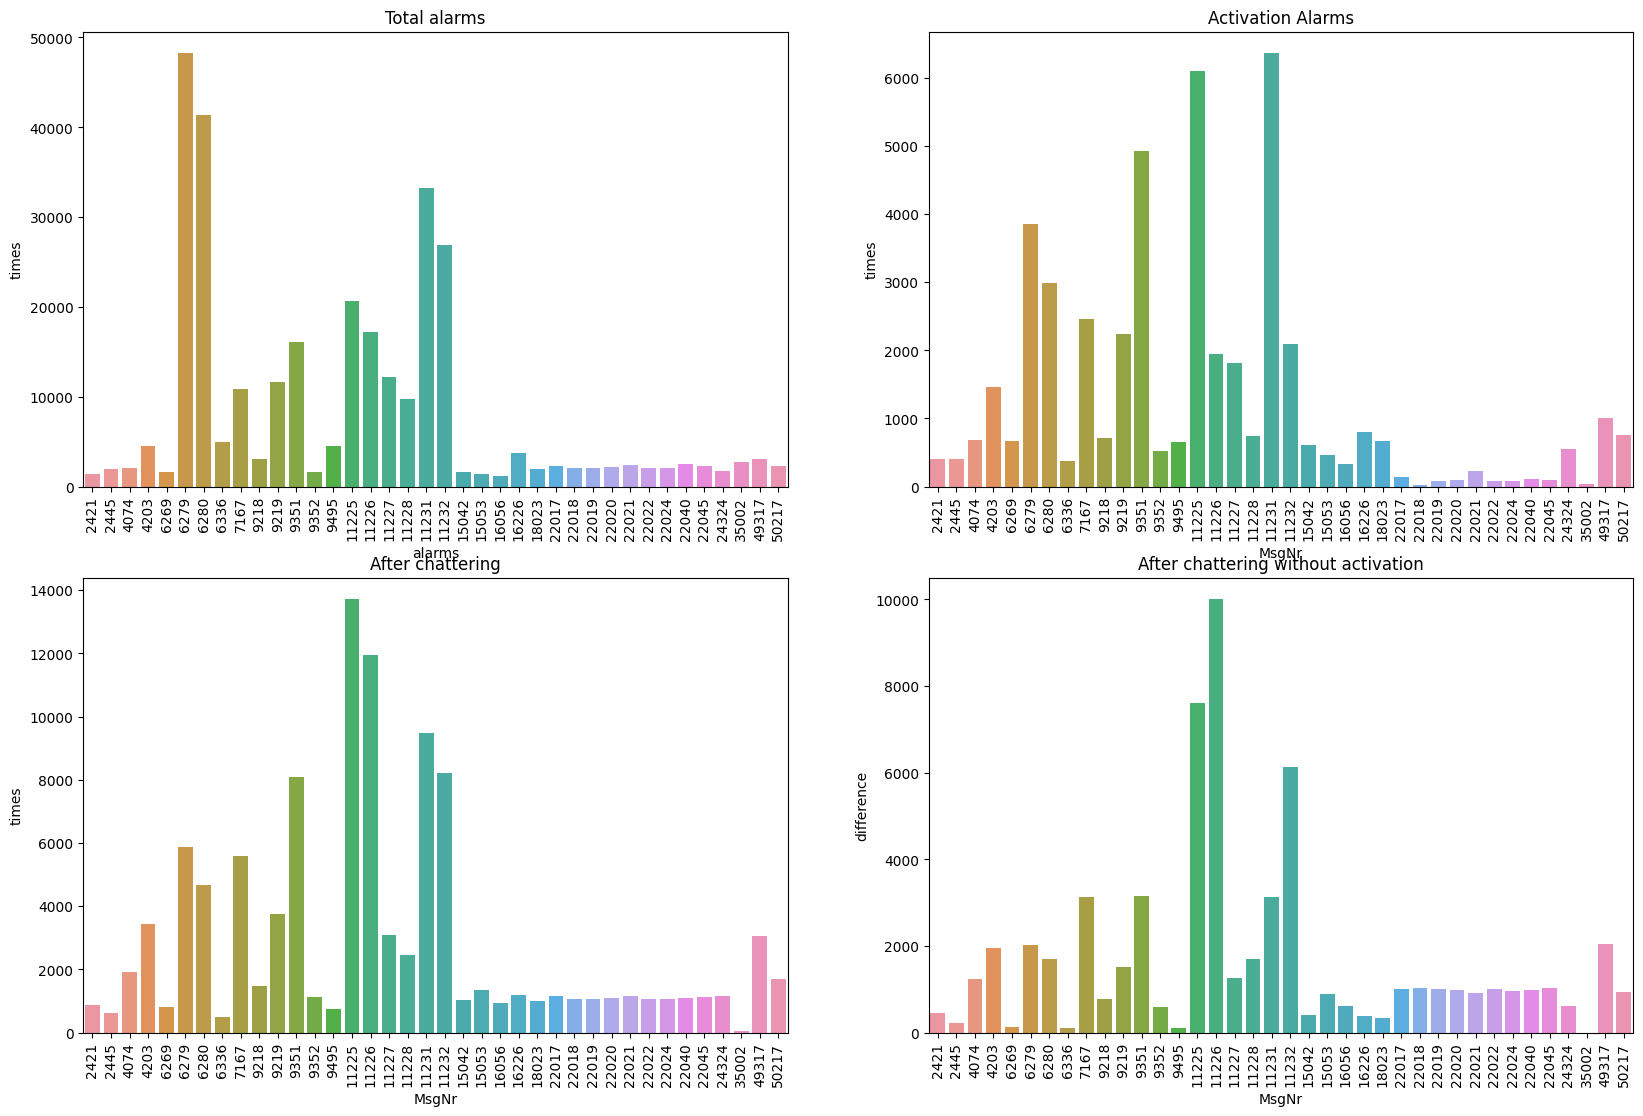

In [16]:
fig, axs = plt.subplots(nrows = 2, ncols= 2, figsize=(20,13))


axs[0,0] = sns.barplot(data=grouped_total, x=grouped_total.index, y='times', ax=axs[0,0])
axs[0,0].tick_params(axis='x', labelrotation=90)
axs[0,0].set_title("Total alarms")

sns.barplot(data=grouped_activation, x=grouped_activation.index, y='times', ax=axs[0, 1])
axs[0, 1].tick_params(axis='x', labelrotation=90)
axs[0, 1].set_title("Activation Alarms")

sns.barplot(data=grouped_total_chattering, x=grouped_activation.index, y='times', ax=axs[1,0])
axs[1, 0].tick_params(axis='x', labelrotation=90)
axs[1, 0].set_title("After chattering")

sns.barplot(data=df_merged, x=grouped_activation.index, y='difference', ax=axs[1,1])
axs[1, 1].tick_params(axis='x', labelrotation=90)
axs[1, 1].set_title("After chattering without activation")




# Display the pie charts
plt.show()

# Apriori

In [20]:
from apyori import apriori

In [21]:
rules = apriori(transactions, min_support=0.01, min_confidence=0.99, min_lift=0, min_length=2)

In [22]:
rule_list=[]

for rule in rules:
    if len(rule.items) > 1:
        sequence = ', '.join([str(item) for item in rule.items])
        support = rule.support
        confidence = rule.ordered_statistics[0].confidence
        lift = rule.ordered_statistics[0].lift
        rule_list.append((sequence, support, confidence, lift))
        print(f"Frequent sequence: {sequence}, Support: {rule.support}, Confidence: {rule.ordered_statistics[0].confidence}, Lift: {rule.ordered_statistics[0].lift}")

Frequent sequence: 11225, 11226, Support: 0.25104523394331574, Confidence: 0.9994981179422836, Lift: 3.4694509859757057
Frequent sequence: 22017, 22018, Support: 0.022102233334033657, Confidence: 0.9924528301886792, Lift: 40.93394918413394
Frequent sequence: 22017, 22019, Support: 0.022501418156606508, Confidence: 0.9962790697674417, Lift: 41.091763330780694
Frequent sequence: 22017, 22022, Support: 0.02254343761161418, Confidence: 0.9962859795728877, Lift: 41.09204832732299
Frequent sequence: 22024, 22017, Support: 0.021955165241506817, Confidence: 0.9971374045801525, Lift: 41.12716555095452
Frequent sequence: 22018, 22019, Support: 0.022102233334033657, Confidence: 0.9924528301886792, Lift: 43.94211847301448
Frequent sequence: 22018, 22020, Support: 0.02216526251654516, Confidence: 0.9952830188679245, Lift: 43.6612772802365
Frequent sequence: 22018, 22021, Support: 0.022081223606529823, Confidence: 0.9915094339622642, Lift: 41.14461597933905
Frequent sequence: 22018, 22022, Support: 

In [23]:
df = pd.DataFrame(rule_list, columns = ['sequences', 'support', 'confidence', 'lift'])
df

,sequences,support,confidence,lift
0,"11225, 11226",0.251045,0.999498,3.469451
1,"22017, 22018",0.022102,0.992453,40.933949
2,"22017, 22019",0.022501,0.996279,41.091763
3,"22017, 22022",0.022543,0.996286,41.092048
4,"22024, 22017",0.021955,0.997137,41.127166
...,...,...,...,...
501,"22017, 22018, 22019, 22021, 22022, 22024, 2204...",0.021409,0.991245,44.384097
502,"22017, 22018, 22020, 22021, 22022, 22024, 2204...",0.021430,0.992218,44.385898
503,"22017, 22019, 22020, 22021, 22022, 22024, 2204...",0.021766,0.991388,44.390474
504,"22018, 22019, 22020, 22021, 22022, 22024, 2204...",0.021409,0.991245,44.384097


In [24]:
class BayesTheorem2:
    
    def __init__(self, transactions):
        self.transactions = transactions

    def calculate_bayes(self, item1, item2):
                
        total_count = len(self.transactions)
        print(total_count)
        
        transactions = [[str(item).strip() for item in sublist] for sublist in self.transactions]

        item1_count_duplicated = sum([i.count(item1) for i in transactions])
        item2_count_duplicated = sum([i.count(item2) for i in transactions])

        item1_count = sum([1 for i in transactions if item1 in set(i)])
        item2_count = sum([1 for i in transactions if item2 in set(i)])

        pA = item1_count/total_count
        pB = item2_count/total_count

        print('item a is', item1_count)

        columnA = [row for row in transactions if item1 in row]
        item2_A = sum([1 for i in columnA if item2 in set(i)])
        print(f'len A {len(columnA)} and item2 {item2_A}')
        # print(columnA)
        pBA = item2_A/(len(columnA))


        bayes =  (pA*pBA)/pB
        print(f'pa is {pA} and pb is {pB} and pba {pBA} and bayes is {bayes}')
        return bayes

In [25]:
# bt = BayesTheorem2('sequences')

bt = BayesTheorem2(transactions)

result = bt.calculate_bayes('22024', '22017')
result

47597
item a is 1048
len A 1048 and item2 1045
pa is 0.022018194424018322 and pb is 0.024245225539424754 and pba 0.9971374045801527 and bayes is 0.9055459272097055


0.9055459272097055

# Filtering sets of lists


In [17]:
data = data_bck.copy()

In [18]:
transactions_dt = data.groupby('sequences').apply(lambda x: {'DateTime': x['DateTime'].tolist(), 'MsgNr': x['MsgNr'].tolist()}).tolist()
transactions_dt.pop(0)
transactions_dt[166]

{'DateTime': ['2022-01-05 12:57:01',
  '2022-01-05 12:58:00',
  '2022-01-05 12:58:31',
  '2022-01-05 12:58:49',
  '2022-01-05 12:59:09',
  '2022-01-05 13:00:05',
  '2022-01-05 13:00:46',
  '2022-01-05 13:01:17',
  '2022-01-05 13:01:42',
  '2022-01-05 13:02:18'],
 'MsgNr': [11232,
  11231,
  11231,
  11231,
  11231,
  11231,
  11231,
  11231,
  11231,
  11232]}

In [19]:
list_of_activation = [11225, 11231]

In [20]:
class getList:
    def transform(data, alarm):
        transactions_clean = [i for i in data if i['MsgNr'][0] == alarm]
        df = pd.DataFrame(transactions_clean)
        df = df.explode('DateTime')
        filename = f'C:/Users/manda/OneDrive - ROCKWOOL Group/Documents/Mthesis/alarms_data/{alarm}.csv'
        with open(filename, 'w') as file:
            df.to_csv(file, index=False)
        return df

In [21]:
for i in list_of_activation:
    datos = getList.transform(transactions_dt, i)

Text(0, 0.5, 'times')

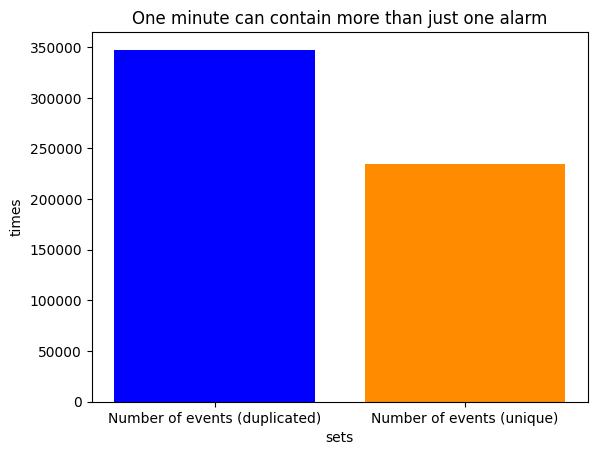

In [22]:
plt.bar(['Number of events (duplicated)', 'Number of events (unique)'], [data.shape[0], data.DateTime.nunique()], color = ["blue", "darkorange"])
plt.title('One minute can contain more than just one alarm')
plt.xlabel("sets")
plt.ylabel("times")